In [53]:
import tensorflow as tf 
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import PIL

In [90]:
img_height = 224
img_width = 224
data_directory = "/Users/ruyutong/Desktop/images"
batch_size = 32
train_ds = tf.keras.utils.image_dataset_from_directory(
   data_directory,
   validation_split=0.2,
   subset="training",
   seed=42, 
   image_size=(img_height, img_width),
   batch_size=batch_size)
val_ds = tf.keras.utils.image_dataset_from_directory(
   data_directory,
   validation_split=0.2,
   subset="validation",
   seed=42, 
   image_size=(img_height, img_width),
   batch_size=batch_size)

Found 1540 files belonging to 7 classes.
Using 1232 files for training.
Found 1540 files belonging to 7 classes.
Using 308 files for validation.


In [91]:
#class_names = ["Berberis Thunbergii","Celtis Occidentalis", "Cercis Canadensis", "Corydalis Incisa","Nyssa Sylvatica","Pinus Virginiana","Quercus Alba"]

In [92]:
class_names = train_ds.class_names
print(class_names)

['Berberis thunbergii', 'Celtis occidentalis', 'Cercis canadensis', 'Corydalis incisa', 'Nyssa sylvatica', 'Pinus virginiana', 'Quercus alba']


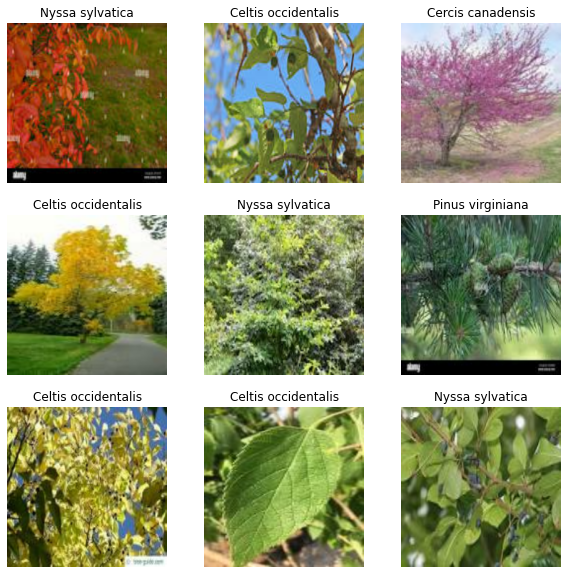

In [93]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [94]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 224, 224, 3)
(32,)


In [95]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [96]:
#Standardizing the data
normalization_layer = layers.Rescaling(1./255)

normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 1.0


In [97]:
#Create a basic Keras Model
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_7 (Rescaling)     (None, 224, 224, 3)       0         
                                                                 
 conv2d_15 (Conv2D)          (None, 224, 224, 16)      448       
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 112, 112, 16)     0         
 g2D)                                                            
                                                                 
 conv2d_16 (Conv2D)          (None, 112, 112, 32)      4640      
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 56, 56, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_17 (Conv2D)          (None, 56, 56, 64)      

In [98]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
39/39 [==============================] - 41s 1s/step - loss: 2.1256 - accuracy: 0.1940 - val_loss: 1.8665 - val_accuracy: 0.2468
Epoch 2/10
39/39 [==============================] - 38s 962ms/step - loss: 1.6666 - accuracy: 0.3604 - val_loss: 1.5766 - val_accuracy: 0.3864
Epoch 3/10
39/39 [==============================] - 39s 999ms/step - loss: 1.3065 - accuracy: 0.5252 - val_loss: 1.3813 - val_accuracy: 0.5195
Epoch 4/10
39/39 [==============================] - 37s 970ms/step - loss: 0.9264 - accuracy: 0.6843 - val_loss: 1.1160 - val_accuracy: 0.6396
Epoch 5/10
39/39 [==============================] - 37s 946ms/step - loss: 0.5561 - accuracy: 0.8166 - val_loss: 1.1134 - val_accuracy: 0.6591
Epoch 6/10
39/39 [==============================] - 38s 965ms/step - loss: 0.3030 - accuracy: 0.9107 - val_loss: 1.3391 - val_accuracy: 0.6429
Epoch 7/10
39/39 [==============================] - 37s 956ms/step - loss: 0.1112 - accuracy: 0.9675 - val_loss: 1.5695 - val_accuracy: 0.6461
Ep

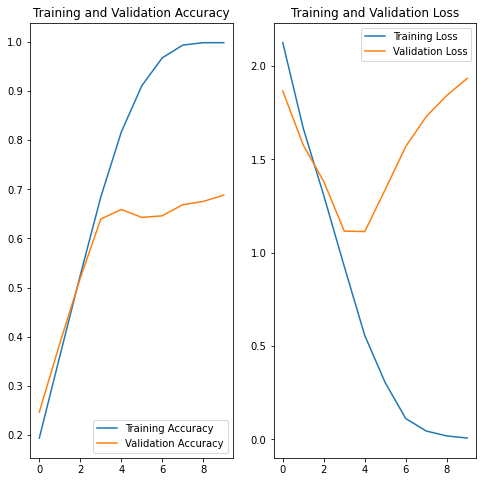

In [99]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [100]:
#Result Interpretation: 
#      In the plots above, the training accuracy is increasing linearly over time, 
# whereas validation accuracy stalls around 60% in the training process. Also, the 
# difference in accuracy between training and validation accuracy is noticeable
# --- a sign of overfitting.

In [109]:
#Dropout
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, name="outputs")
])

In [110]:
#Data Augmentation
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",input_shape=(img_height,img_width,3)),
    layers.RandomZoom(0.1),
    layers.RandomBrightness(factor=0.2)
  ]
)

In [111]:
# plt.figure(figsize=(10, 10))
# for images, _ in train_ds.take(1):
#   for i in range(9):
#     augmented_images = data_augmentation(images)
#     ax = plt.subplot(3, 3, i + 1)
#     plt.imshow(augmented_images[0].numpy().astype("uint8"))
#     plt.axis("off")

In [112]:
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, name="outputs")
])

In [113]:
#Compile the model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [114]:
#Train again with the alterated data
epochs = 15
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/15
39/39 [==============================] - 52s 1s/step - loss: 2.0191 - accuracy: 0.2265 - val_loss: 1.7235 - val_accuracy: 0.3312
Epoch 2/15
39/39 [==============================] - 44s 1s/step - loss: 1.6713 - accuracy: 0.3669 - val_loss: 1.4761 - val_accuracy: 0.4351
Epoch 3/15
39/39 [==============================] - 46s 1s/step - loss: 1.4269 - accuracy: 0.4619 - val_loss: 1.2769 - val_accuracy: 0.5260
Epoch 4/15
39/39 [==============================] - 43s 1s/step - loss: 1.2354 - accuracy: 0.5528 - val_loss: 1.2486 - val_accuracy: 0.5195
Epoch 5/15
39/39 [==============================] - 43s 1s/step - loss: 1.1935 - accuracy: 0.5787 - val_loss: 1.1947 - val_accuracy: 0.5714
Epoch 6/15
39/39 [==============================] - 45s 1s/step - loss: 1.0794 - accuracy: 0.6136 - val_loss: 1.0873 - val_accuracy: 0.6006
Epoch 7/15
39/39 [==============================] - 45s 1s/step - loss: 0.8787 - accuracy: 0.6859 - val_loss: 1.1106 - val_accuracy: 0.6136
Epoch 8/15
39/39 [==

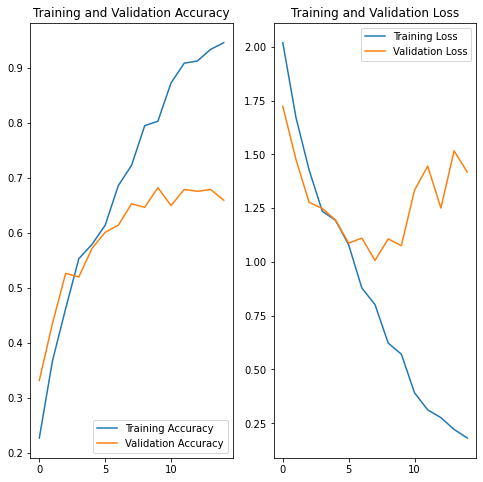

In [115]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [127]:
Sample_photo_url = 'https://scontent-iad3-1.xx.fbcdn.net/v/t39.30808-6/244745833_4659441740835015_4116921199421298610_n.jpg'
Sample_path = tf.keras.utils.get_file('Wyman_Park_Tree', origin=Sample_photo_url)

img = tf.keras.utils.load_img(
    Sample_path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

1/1 [==============================] - 0s 109ms/step
This image most likely belongs to Quercus alba with a 99.64 percent confidence.
